In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy import stats as sps

import pytensor.tensor as ptt

import icomo

import jax
import jax.numpy as jnp

plt.rcParams.update({'font.size': 8})

In [2]:
def bootstrap_confidence_interval(data, n=1000, func=np.mean, alpha=0.05):
    resamples = np.random.choice(data.dropna(), size=(n, len(data.dropna())), replace=True)
    perc = np.percentile([func(r) for r in resamples], [100*alpha/2, 100*(1-alpha/2)])
    return [func(data.dropna()) - perc[0], perc[1] - func(data.dropna())]

def percentile_confidence_interval(data, alpha=0.05):
    perc = np.percentile(data.dropna(), [100*alpha/2, 100*(1-alpha/2)])
    return [data.mean() - perc[0], perc[1] - data.mean()]

# System definition

In [3]:
# standard parameters
_RATE_RECOVER = 1.0 / 3.0
_RATE_LOAD = 1.0 / 0.5
_RATE_DOCK = 1.0 / 1.0
_RATE_PRIME = 1.0 / 0.1
_MAX_RECOVERY = 38.0
_MAX_LOADED = 38.0
_MAX_DOCKED = 20.0
_MAX_PRIMED = 4.0
_MAX_FUSED = 100.0
_RELEASE_PROBABILITY = 0.2

# Define the differential equations
def equations(t, y, args):
    t_args, const_args = args

    RATE_RECOVER = const_args["RATE_RECOVER"]
    RATE_LOAD = const_args["RATE_LOAD"]
    RATE_DOCK = const_args["RATE_DOCK"]
    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_RECOVERY = const_args["MAX_RECOVERY"]
    MAX_LOADED = const_args["MAX_LOADED"]
    MAX_DOCKED = const_args["MAX_DOCKED"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    recovery = y["recovery"]
    loaded = y["loaded"]
    docked = y["docked"]
    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_recovery = RATE_RECOVER * (fused > 0) * (recovery <= MAX_RECOVERY)
    recovery_to_loaded = 4 * RATE_LOAD * (recovery / MAX_RECOVERY) * (1 - loaded / MAX_LOADED)
    loaded_to_docked = 4 * RATE_DOCK * (loaded / MAX_LOADED) * (1 - docked / MAX_DOCKED)
    docked_to_primed = 2 * RATE_PRIME * (docked / MAX_DOCKED) * (1 - primed / MAX_PRIMED)

    drecovery = fused_to_recovery - recovery_to_loaded
    dloaded = recovery_to_loaded - loaded_to_docked
    ddocked = loaded_to_docked - docked_to_primed
    dprimed = docked_to_primed
    dfused = - fused_to_recovery

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t) 
    dprimed -= release
    dfused += release

    dy = {
        "recovery": drecovery,
        "loaded": dloaded,
        "docked": ddocked,
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

# Depression test

In [4]:
len_sim = 10 * 60 # s
pps = 34 # points per second
num_points = int(len_sim * pps) 

### First set the time variables
t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
t_stim = t_solve_ODE # timepoints at which the stimulus is defined
t_out = t_solve_ODE # timepoints at which the output is saved

### Set parameters  for ODE
stim = 50 * np.ones(len(t_stim))
t_args = stim

const_args = {
    "RATE_RECOVER": _RATE_RECOVER,
    "RATE_LOAD": _RATE_LOAD,
    "RATE_DOCK": _RATE_DOCK,
    "RATE_PRIME": _RATE_PRIME,
    "MAX_RECOVERY": _MAX_RECOVERY,
    "MAX_LOADED": _MAX_LOADED,
    "MAX_DOCKED": _MAX_DOCKED,
    "MAX_PRIMED": _MAX_PRIMED,
    "RELEASE_PROBABILITY": _RELEASE_PROBABILITY,
}

### Define starting conditions
y0 = {"recovery": _MAX_RECOVERY, "loaded": _MAX_LOADED, "docked": _MAX_DOCKED, "primed": _MAX_PRIMED, "fused": 0.0}

# First parameters of the integrators have to be set
integrator_object = icomo.ODEIntegrator(
    ts_out=t_out,
    t_0=min(t_solve_ODE),
    ts_solver=t_solve_ODE,
    ts_arg=t_stim,
    max_steps=len(t_solve_ODE),
)

# Then we can obtain a function that solves our system of ODEs
integrator = integrator_object.get_func(equations)

# And solve the ODE for our starting conditions and parameters
y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
keys = ["recovery", "loaded", "docked", "primed", "fused"]
output = np.array([y[k] for k in keys]).T



/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_49909/1118841220.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


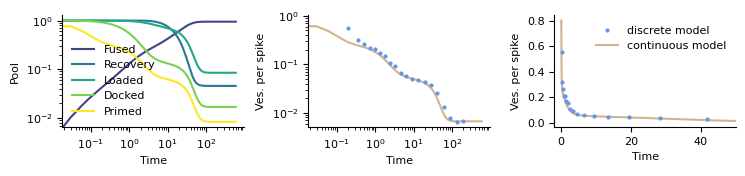

In [5]:

# pool sizes
f = plt.figure(figsize=(3*2.5,1.8))
axs = f.subplots(1,3)

normalization = np.array([_MAX_RECOVERY, _MAX_LOADED, _MAX_DOCKED, _MAX_PRIMED, _MAX_FUSED])
norm_out = output / normalization
# reorder fused pool first
norm_out = norm_out[:,[4,0,1,2,3]]
axs[0].plot(t_out, norm_out)
# log scale
axs[0].set_yscale("log")
axs[0].set_xscale("log")

import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')
colors = [cmap(1 - (4-i)/5) for i in range(5)]
for i,j in enumerate(axs[0].lines):
    j.set_color(colors[i])

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Pool")
axs[0].legend(["Fused", "Recovery", "Loaded", "Docked", "Primed"], frameon=False)
# remove top and right spines
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# compare discrete and continuous release
filename = "../fig2/depression_test_50Hz.h5"
dic = h5py.File(filename, 'r')

ves_per_spike = dic.get('ves_per_spike')[()] 
ves_per_spike_mean = np.mean(ves_per_spike, axis=1)
ps = dic.get('ps')[()]
sizes = dic.get('sizes')[()]
test_times = dic.get('test_times')[()]

i_p = np.where(ps == 0.2)[0][0]
i_size = np.where(sizes == 1.0)[0][0]
sim_data = ves_per_spike_mean[:,i_p,i_size]

primed = output[:,3]
release_rate = primed * stim * _RELEASE_PROBABILITY
ves_per_spike = release_rate / stim

axs[1].plot(test_times, sim_data,
    linestyle='None', marker='o', zorder=2, markersize=2.0, label="discrete model", 
    color='cornflowerblue')
axs[1].plot(t_out, ves_per_spike, label="continuous model", color='tan', zorder=1)
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Ves. per spike");
# remove top and right spines
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# compare discrete and continuous release regular scale
axs[2].plot(test_times, sim_data,
    linestyle='None', marker='o', zorder=2, markersize=2.0, label="discrete model", 
    color='cornflowerblue')
inds = np.where(t_out <= 200)[0]
axs[2].plot(t_out[inds], ves_per_spike[inds], label="continuous model", color='tan', zorder=1)
axs[2].legend(frameon=False)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Ves. per spike");
axs[2].set_xlim([-2,50])
# remove top and right spines
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)


f.tight_layout()
f.savefig("compare_discrete_continuous.pdf")

In [6]:
conditions = [(T_exh, T_pause) for T_exh in [0.4, 4, 40.0] for T_pause in [1.0, 10, 40.0, 100]]
outputs = []
stims = []

p = 0.37

len_sim = 10 * 20 # s
pps = 10 # points per second
num_points = int(len_sim * pps) 

for condition in conditions:
    T_exh, T_pause = condition

    ### First set the time variables
    t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
    t_stim = t_solve_ODE # timepoints at which the stimulus is defined
    t_out = t_solve_ODE # timepoints at which the output is saved

    ### Set parameters  for ODE
    stim = 20 * np.ones(len(t_stim))
    stim[np.logical_and(t_stim > T_exh, t_stim < T_exh + T_pause)] = 0
    t_args = stim
    stims.append(stim)

    const_args = {
        "RATE_RECOVER": _RATE_RECOVER,
        "RATE_LOAD": _RATE_LOAD,
        "RATE_DOCK": _RATE_DOCK,
        "RATE_PRIME": _RATE_PRIME,
        "MAX_RECOVERY": _MAX_RECOVERY,
        "MAX_LOADED": _MAX_LOADED,
        "MAX_DOCKED": _MAX_DOCKED,
        "MAX_PRIMED": _MAX_PRIMED,
        "RELEASE_PROBABILITY": p,
    }

    ### Define starting conditions
    y0 = {"recovery": _MAX_RECOVERY, "loaded": _MAX_LOADED, "docked": _MAX_DOCKED, "primed": _MAX_PRIMED, "fused": 0.0}

    # First parameters of the integrators have to be set
    integrator_object = icomo.ODEIntegrator(
        ts_out=t_out,
        t_0=min(t_solve_ODE),
        ts_solver=t_solve_ODE,
        ts_arg=t_stim,
        max_steps=len(t_solve_ODE),
    )

    # Then we can obtain a function that solves our system of ODEs
    integrator = integrator_object.get_func(equations)

    # And solve the ODE for our starting conditions and parameters
    y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
    keys = ["recovery", "loaded", "docked", "primed", "fused"]
    output = np.array([y[k] for k in keys]).T
    output /= normalization

    outputs.append(output)

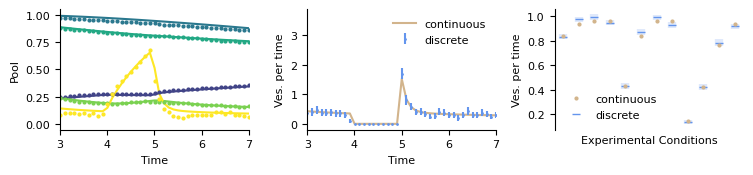

In [7]:

filename = "discrete_experiment.h5"

dic = h5py.File(filename, 'r')

ps = dic.get('ps')[()]
sizes = dic.get('sizes')[()]
binned_pool_levels = dic.get('binned_pool_levels')[()]
binned_vesicle_releases = dic.get('binned_vesicle_releases')[()]
bins_ts = dic.get('bins_ts')[()]
conditions_jl = dic.get('conditions')[()]

i_p = np.where(ps == p)[0][0]
i_size = np.where(sizes == 1.0)[0][0]

discrete_releases = []
continuous_releases = []

for i_cond, condition in enumerate(conditions):
    T_exh, T_pause = condition
    stim = stims[i_cond]
    inds_sim = [4,0,1,2,3]
    output = outputs[i_cond][:,inds_sim]

    inds = [5,0,1,2,3]
    pools = binned_pool_levels[inds,:,:,i_cond,i_p,i_size]
    vesicles = binned_vesicle_releases[:,:,i_cond,i_p,i_size]

    inds = np.where(np.logical_and(bins_ts >= T_exh + T_pause, bins_ts < T_exh + T_pause + 2))[0]
    discrete_release = np.mean(vesicles[inds,:], axis=0)
    discrete_releases.append(discrete_release)

    inds = np.where(np.logical_and(t_out >= T_exh + T_pause, t_out < T_exh + T_pause + 2))[0]
    # convert normalized primed pool to vesicles released per second (4: primed pool sizes, pps: points per second)
    release_rate = output[inds,-1] * 4 * stim[inds] * p / pps 
    continuous_release = np.mean(release_rate)
    continuous_releases.append(continuous_release)

    if i_cond == 4:
        fig, axs = plt.subplots(1,3, figsize=(3*2.5,1.8))

        axs[0].plot(t_out, output)
        axs[0].plot(bins_ts, np.mean(pools, axis=2).T,  
                        linestyle='', marker='o', markersize=2.0)
        axs[0].set_xlabel("Time")
        axs[0].set_ylabel("Pool")
        axs[0].set_xlim([T_exh+T_pause-2,T_exh+T_pause+2])
        for i,j in enumerate(axs[0].lines):
            j.set_color(colors[i%5])
        # remove top and right spines
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)

        release_rate = output[:,-1] * 4 * stim * p / pps
        axs[1].plot(t_out, release_rate, label="continuous", color='tan')
        axs[1].errorbar(bins_ts, np.mean(vesicles, axis=1), label="discrete", color='cornflowerblue',
                        yerr=1.96*sps.sem(vesicles, axis=1), linestyle='', marker='o', markersize=1.0)
        axs[1].set_xlabel("Time")
        axs[1].set_ylabel("Ves. per time")
        axs[1].set_xlim([T_exh+T_pause-2,T_exh+T_pause+2])
        axs[1].legend(frameon=False)
        # remove top and right spines
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)



discrete_releases = np.array(discrete_releases)
continuous_releases = np.array(continuous_releases)
cond_names = [f"{T_exh}_{T_pause}" for T_exh, T_pause in conditions]

axs[2].plot(cond_names, continuous_releases, label='continuous', color='tan', linestyle='', marker='o', markersize=2.0, zorder=3)
axs[2].plot(cond_names, np.mean(discrete_releases, axis=1), label="discrete", color='cornflowerblue',
            linestyle='', marker='_', markersize=6.0, zorder=1)
axs[2].errorbar(cond_names, np.mean(discrete_releases, axis=1), 
                yerr=1.96 * sps.sem(discrete_releases, axis=1), linestyle='', marker='', markersize=0.0, 
                elinewidth=6, color='cornflowerblue', alpha=0.2, zorder=2)
axs[2].set_xlabel("Experimental Conditions")
axs[2].set_ylabel("Ves. per time")
axs[2].legend(frameon=False)
# remove top and right spines and bottom
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].set_xticks([])


plt.tight_layout()
plt.savefig("discrete_continuous_comparison.pdf")
plt.show()


# Adaptive depression test

/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_49909/1956948494.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('bone')


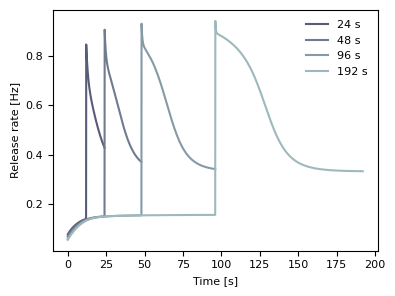

In [8]:
len_sim = 576*6 # s
pps = 10 # points per second
num_points = int(len_sim * pps)

### First set the time variables
t_out = np.linspace(0, len_sim, num_points) # timepoints of the output
t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE
                                                     # is solved
t_stim = t_solve_ODE # timepoints at which the stimulus is defined

### Set parameters  for ODE
stim = np.ones(len(t_stim))
stim_freq = 1 # Hz
n_blocks = 6
block_length = num_points // n_blocks
block_T = [2**i*6 for i in range(n_blocks)]
for i in range(n_blocks):
    stim[i*block_length:(i+1)*block_length] = [(t % block_T[i] > block_T[i] / 2) for t in t_stim[i*block_length:(i+1)*block_length]]

stim = stim * stim_freq + 0.2


t_args = stim

const_args = {
    "RATE_RECOVER": _RATE_RECOVER,
    "RATE_LOAD": _RATE_LOAD,
    "RATE_DOCK": _RATE_DOCK,
    "RATE_PRIME": _RATE_PRIME,
    "MAX_RECOVERY": _MAX_RECOVERY,
    "MAX_LOADED": _MAX_LOADED,
    "MAX_DOCKED": _MAX_DOCKED,
    "MAX_PRIMED": _MAX_PRIMED,
    "RELEASE_PROBABILITY": _RELEASE_PROBABILITY,
}

### Define starting conditions
y0 = {"recovery": _MAX_RECOVERY, "loaded": _MAX_LOADED, "docked": _MAX_DOCKED, "primed": _MAX_PRIMED, "fused": 0.0}

# First parameters of the integrators have to be set
integrator_object = icomo.ODEIntegrator(
    ts_out=t_out,
    t_0=min(t_solve_ODE),
    ts_solver=t_solve_ODE,
    ts_arg=t_stim,
    max_steps=len(t_solve_ODE),
)

# Then we can obtain a function that solves our system of ODEs
integrator = integrator_object.get_func(equations)

# And solve the ODE for our starting conditions and parameters
y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
primed = y["primed"]
release_rate = primed * stim * _RELEASE_PROBABILITY

f = plt.figure(figsize=(4,3))
labels = ["{} s".format(block_T[i]) for i in range(n_blocks)]
from matplotlib.cm import get_cmap
cmap = get_cmap('bone')
colors = cmap(np.linspace(0.2,0.7,n_blocks))
for i in range(2,n_blocks):
    plt.plot(t_out[:block_T[i]*pps], release_rate[i*block_length:i*block_length+block_T[i]*pps], color=colors[i], label=labels[i])
plt.legend(frameon=False)
plt.xlabel("Time [s]")
plt.ylabel("Release rate [Hz]");
plt.tight_layout()
plt.savefig("dynamic_release_rate.pdf")


# Fit to experiment

In [9]:
# get experimental data from xls
excel_file = "exp1_data.xlsx" # change path to the location of your file
df1 = pd.read_excel(excel_file)

# load exhaustion experiment data from xls
excel_file = "exp2_data.xlsx" 
df2 = pd.read_excel(excel_file)
data2 = df2[df2.columns[1:]].values.T
time = df2["seconds"].values
print(data2.shape)
print(time.shape)
experimental_fusion_rate = np.diff(data2) / np.diff(time)
experimental_fusion_rate = np.concatenate([experimental_fusion_rate, np.zeros((experimental_fusion_rate.shape[0],1))], axis=1)
print(experimental_fusion_rate.shape)

# stim starts at 32.35 s
stim_start = 32.35
inds = time > stim_start
time = time[inds] - time[inds][0]
data2 = data2[:,inds]
# start at 0 not 1
data2 = data2 - data2[:,[0]]
experimental_fusion_rate = experimental_fusion_rate[:,inds]
print(data2.shape)
print(time.shape)

data2_means = np.mean(data2, axis=0)
data2_errs = np.std(data2, axis=0) / np.sqrt(data2.shape[0])

(1231, 170)
(170,)
(1231, 170)
(1231, 116)
(116,)


In [10]:
pps = 10 # points per second

def get_integrator_object(depletiontime, pausetime, testtime):
    len_sim = depletiontime + pausetime + testtime # s
    num_points = int(len_sim * pps)

    t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
    t_stim = t_solve_ODE # timepoints at which the stimulus is defined

    # only return the output during the test time
    t_out_inds = np.logical_and((t_solve_ODE > depletiontime + pausetime), (t_solve_ODE < depletiontime + pausetime + testtime))
    t_out = t_solve_ODE[t_out_inds]

    integrator_object = icomo.ODEIntegrator(
        ts_out=t_out,
        t_0=min(t_solve_ODE),
        ts_solver=t_solve_ODE,
        ts_arg=t_stim,
        max_steps=len(t_solve_ODE),
    )
    return integrator_object, t_stim

def get_integrator_object2():

    len_sim = 70 # s
    pps = 17 # points per second later scaled to 1.7 by taking mod 20
    num_points = int(len_sim * pps) + 1

    ### First set the time variables
    t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
    t_stim = t_solve_ODE # timepoints at which the stimulus is defined

    inds = (np.arange(len(t_solve_ODE)) % 10 == 0) & (t_solve_ODE <= time[-1])
    t_out = t_solve_ODE[inds] # timepoints at which the output is saved
    assert np.all(np.isclose(t_out, time))

    # First parameters of the integrators have to be set
    integrator_object = icomo.ODEIntegrator(
        ts_out=t_out,
        t_0=min(t_solve_ODE),
        ts_solver=t_solve_ODE,
        ts_arg=t_stim,
        max_steps=len(t_solve_ODE),
    )
    return integrator_object, t_stim

def get_lognormal_params(mean, std):
    sigma = np.sqrt(np.log(std**2 / mean**2 + 1))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

with pm.Model() as model:

    ###### Priors on the model parameters

    precision = 3
    mu, sigma = get_lognormal_params(_MAX_RECOVERY, _MAX_RECOVERY/precision)
    max_recovery = pm.LogNormal("max_recovery", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_LOADED, _MAX_LOADED/precision)
    max_loaded = pm.LogNormal("max_loaded", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_DOCKED, _MAX_DOCKED/precision)
    max_docked = pm.LogNormal("max_docked", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_PRIMED, _MAX_PRIMED/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 3
    mu, sigma = get_lognormal_params(_RATE_RECOVER, _RATE_RECOVER/precision)
    rate_recover = pm.LogNormal("rate_recover", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_LOAD, _RATE_LOAD/precision)
    rate_load = pm.LogNormal("rate_load", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_DOCK, _RATE_DOCK/precision)
    rate_dock = pm.LogNormal("rate_dock", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_PRIME, _RATE_PRIME/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability1 = pm.Beta("release_probability1", alpha=1, beta=2)
    release_probability2 = pm.Beta("release_probability2", alpha=1, beta=2)
    # additional factor to scale from num vesicles to calcium data
    observation_factor1 = pm.HalfFlat("observation_factor1")
    error_model1 = pm.HalfCauchy("error_model1", beta=0.1)
    # additional factor to scale from num vesicles to calcium data
    observation_factor2 = pm.HalfFlat("observation_factor2")
    error_model2 = pm.HalfCauchy("error_model2", beta=0.3)

    const_args_var1 = {
        "RATE_RECOVER": rate_recover,
        "RATE_LOAD": rate_load,
        "RATE_DOCK": rate_dock,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_LOADED": max_loaded,
        "MAX_DOCKED": max_docked,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability1,
    }

    const_args_var2 = {
        "RATE_RECOVER": rate_recover,
        "RATE_LOAD": rate_load,
        "RATE_DOCK": rate_dock,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_LOADED": max_loaded,
        "MAX_DOCKED": max_docked,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability2,
    }


    ###### experiment 1

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"recovery": max_recovery, "loaded": max_loaded, "docked": max_docked, "primed": max_primed, "fused": 0.0}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var1)
        # util = calcium + ca_increase * (1 - calcium) 
        release_rate = primed * stim_rate * release_probability1 #*util
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor1 * released)

        # get data and simulation results
        data1 = df1[condition_name]
        error_of_the_mean = np.std(data1) / np.sqrt(len(data1))
        data1_mean = np.mean(data1)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model1 + error_of_the_mean)
        
        sim.append(observation_factor1 * released)
        sim_error.append(sigma_error)
        obs.append(data1_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    mu1 = sim
    sigma1 = sim_error
    observed1 = obs


    ###### experiment 2
    
    stim_rate = 5.0 # Hz
    max_vesicles = _MAX_FUSED + max_loaded + max_docked + max_primed


    ### Define starting conditions
    y0 = {"recovery": max_recovery, "loaded": max_loaded, "docked": max_docked, "primed": max_primed, "fused": 0.0}

    # Get integrator object
    integrator_object, ts = get_integrator_object2()
    integrator = integrator_object.get_op(equations, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])

    ### Set input
    stim = stim_rate * np.ones(len(ts))
    t_args = stim

    # And solve the ODE for our starting conditions and parameters
    primed, _ = integrator(y0=y0, arg_t=t_args, constant_args=const_args_var2)

    release_rate = primed * stim_rate * release_probability2
    pps_experiment = 1.7
    fused = pm.math.cumsum(release_rate) / pps_experiment # have to get total number of vesicles released
    fused -= fused[0]

    # ### alternatively 
    # fused = release_rate / pps_experiment
    # # define ft = 1 - #tagged vesicles / #total vesicles
    # inv_rel_fraction = 1 - fused / max_vesicles
    # # then we can compute with cumprod the fraction of tagged vesicles
    # ft = pm.math.cumprod(inv_rel_fraction)
    # tagged = max_vesicles * (1 - ft)

    out = pm.Deterministic("experiment2", observation_factor2 * fused)
    sim2_errors = pm.Deterministic("scaled_sigma_error_experiment2", error_model2 + data2_errs)

    mu2 = out
    sigma2 = sim2_errors
    observed2 = data2_means

    observed = np.concatenate([observed1, observed2])
    mu = ptt.concatenate([mu1, mu2])
    sigma = ptt.concatenate([sigma1, sigma2])

    def logp(observed, mu, sigma):
        n = 13

        observed1 = observed[:n]
        observed2 = observed[n:]
        mu1 = mu[:n]
        mu2 = mu[n:]
        sigma1 = sigma[:n]
        sigma2 = sigma[n:]
        weight1 = 10
        weight2 = 1
        normalizer = weight1 + weight2
        weight1 /= normalizer / 2
        weight2 /= normalizer / 2
        p1 = pm.logp(pm.Normal.dist(mu1, sigma1),observed1)
        p2 = pm.logp(pm.Normal.dist(mu2, sigma2),observed2)
        return ptt.concatenate([weight1 * p1, weight2 * p2])
         
    pm.CustomDist("likelihood",
                    mu, sigma,
                    logp = logp,
                    observed = observed)
    

In [11]:
# # map estimate
# map_estimate = pm.find_MAP(model=model)
# print(map_estimate)

In [12]:

# # get the posterior
# sim_df = pd.DataFrame()
# for condition in conditions:
#     depletiontime, pausetime = condition
#     condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
#     sim_df[condition_name] = np.array([map_estimate[condition_name]])

# fig = plt.figure(figsize=(3.5,2.8))
# ax = fig.subplots(1,1)

# # offset points
# import matplotlib.transforms as transforms
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, fig.dpi_scale_trans)
# trans = ax.transData

# # remove the right and top and bottom spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# errs_df = df1.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
# plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
# plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

# errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
# plt.plot(sim_df.columns, sim_df.mean(), linestyle='None', marker='o', color='cornflowerblue')

# plt.xticks(rotation=45)
# plt.ylabel("change in dF/F")
# plt.tight_layout()
# plt.savefig("posterior_full_comparison.pdf", bbox_inches='tight')

In [13]:
# # get the posteriors
# simulation_results = np.array([map_estimate["experiment2"]])

# simulation_results_mean = np.mean(simulation_results, axis=0)
# # simulation_results_conf = np.percentile(simulation_results, [2.5, 97.5], axis=0)

# deviation = np.std(data2, axis=0) / np.sqrt(data2.shape[0])
# experiment_conf = data2_means + 1.96 * np.array([-deviation, deviation])

# fig, axs = plt.subplots(1,1, figsize=(2.5,2))
# axs.plot(time, data2_means, label="Experimental data", alpha=0.2, color='black')
# axs.fill_between(time, experiment_conf[0], experiment_conf[1], alpha=0.2, color='black')
# axs.plot(time, simulation_results_mean, label="Model prediction", color='cornflowerblue')
# # axs.fill_between(time, simulation_results_conf[0], simulation_results_conf[1], alpha=0.2, color='cornflowerblue')
# axs.set_xlabel("Time [s]")
# axs.set_ylabel("Flourescence increase")
# axs.spines['top'].set_visible(False)
# axs.spines['right'].set_visible(False)
# axs.legend()


# plt.tight_layout() 
# plt.savefig("exhaustion_comparison.pdf", bbox_inches='tight')
# plt.show()

In [ ]:
# sample the model
trace = pm.sample(
    model=model,
    tune=800,
    draws=2500,
    cores=4,
    nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
    nuts_sampler="numpyro",
    target_accept=0.90,
)

# save the trace
az.to_netcdf(trace, "trace.nc")

In [15]:
# load the trace
trace = az.from_netcdf("trace.nc")
# if chains do not converge throw them out
trace_full = trace
trace = trace_full.sel(chain=[1,3])
print(az.rhat(trace))

<xarray.Dataset>
Dimensions:                               (experiment2_dim_0: 116,
                                           scaled_sigma_error_experiment2_dim_0: 116)
Coordinates:
  * experiment2_dim_0                     (experiment2_dim_0) int64 0 1 ... 115
  * scaled_sigma_error_experiment2_dim_0  (scaled_sigma_error_experiment2_dim_0) int64 ...
Data variables: (12/42)
    0.4_1                                 float64 1.001
    0.4_10                                float64 1.001
    0.4_100                               float64 1.001
    0.4_40                                float64 1.001
    40_1                                  float64 1.0
    40_10                                 float64 1.0
    ...                                    ...
    scaled_sigma_error_40_40              float64 1.0
    scaled_sigma_error_4_1                float64 1.0
    scaled_sigma_error_4_10               float64 1.0
    scaled_sigma_error_4_100              float64 1.0
    scaled_sigma_error_4_40

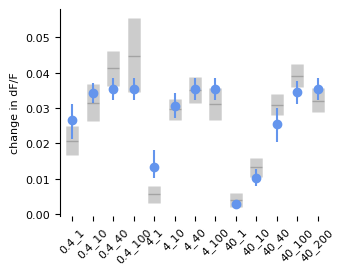

In [16]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# offset points
import matplotlib.transforms as transforms
offset = lambda p: transforms.ScaledTranslation(p/72.,0, fig.dpi_scale_trans)
trans = ax.transData

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df1.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=errs_sim_df, linestyle='None', marker='o', color='cornflowerblue')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")
plt.tight_layout()
plt.savefig("posterior_full_exp1.pdf", bbox_inches='tight')


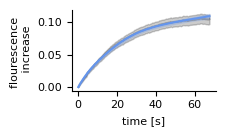

In [17]:
# get the posteriors
simulation_results = trace.posterior["experiment2"].to_numpy().reshape(-1, data2.shape[1])

simulation_results_mean = np.mean(simulation_results, axis=0)
simulation_results_conf = np.percentile(simulation_results, [2.5, 97.5], axis=0)

deviation = np.std(data2, axis=0) / np.sqrt(data2.shape[0])
experiment_conf = data2_means + 1.96 * np.array([-deviation, deviation])

fig, axs = plt.subplots(1,1, figsize=(2.3,1.4))
axs.plot(time, data2_means, label="Experimental data", alpha=0.2, color='black')
axs.fill_between(time, experiment_conf[0], experiment_conf[1], alpha=0.2, color='black')
axs.plot(time, simulation_results_mean, label="Model prediction", color='cornflowerblue')
axs.fill_between(time, simulation_results_conf[0], simulation_results_conf[1], alpha=0.2, color='cornflowerblue')
axs.set_xlabel("time [s]")
axs.set_ylabel("flourescence \n increase")
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.legend()

plt.tight_layout() 
plt.savefig("posterior_full_exp2.pdf", bbox_inches='tight')
plt.show()

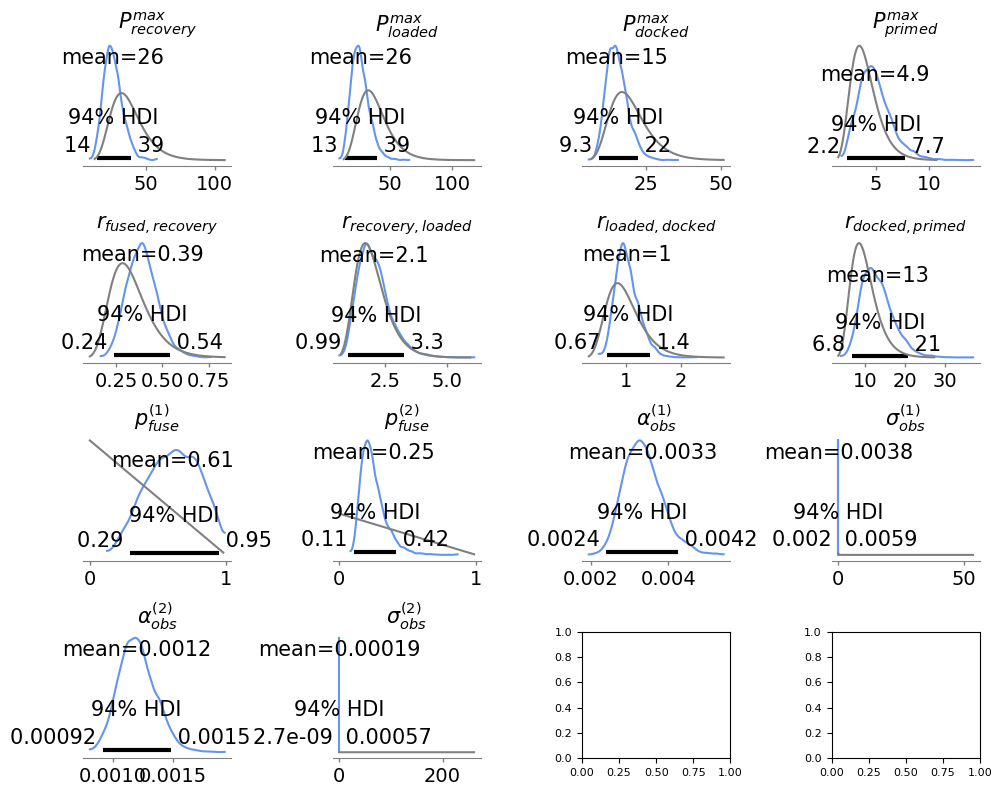

In [18]:
def plot_cont(prior, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = pm.draw(prior, draws=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(pm.logp(prior,x)).eval(), color='gray')
    return ax

condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions]

name_dict = {
    "max_recovery": r"$P^{max}_{recovery}$",
    "max_loaded": r"$P^{max}_{loaded}$",
    "max_docked": r"$P^{max}_{docked}$",
    "max_primed": r"$P^{max}_{primed}$",
    "rate_recover": r"$r_{fused,recovery}$",
    "rate_load": r"$r_{recovery,loaded}$",
    "rate_dock": r"$r_{loaded,docked}$",
    "rate_prime": r"$r_{docked,primed}$",
    "release_probability1": r"$p^{(1)}_{fuse}$",
    "release_probability2": r"$p^{(2)}_{fuse}$",
    "observation_factor1": r"$\alpha_{obs}^{(1)}$",
    "observation_factor2": r"$\alpha_{obs}^{(2)}$",
    "error_model1": r"$\sigma_{obs}^{(1)}$",
    "error_model2": r"$\sigma_{obs}^{(2)}$",
    "rate_ca": r"$r_{ca}$",
    "ca_increase": r"$\Delta_{ca}$",
}

# for each variable plot prior and posterior
names = [var.name for var in model.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names]) and not "experiment2" in name
names = list(filter(fl, names))

sidelength = int(np.ceil(np.sqrt(len(names))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names, range(len(names))):
    ax = axs[i]

    pm.plot_posterior(trace, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_full.pdf", bbox_inches='tight')



In [19]:
print(az.summary(trace))
# keys = list(const_args_var.keys())
# keys = [k.lower() for k in keys]
# az.plot_forest(trace, var_names=keys, combined=True, hdi_prob=0.95, transform=lambda x: np.log10(x))
# az.plot_forest(trace, var_names=["error_model"], combined=True, hdi_prob=0.95)

                                      mean     sd  hdi_3%  hdi_97%  mcse_mean  \
0.4_1                                0.026  0.003   0.022    0.031        0.0   
0.4_10                               0.034  0.001   0.031    0.037        0.0   
0.4_100                              0.035  0.002   0.032    0.038        0.0   
0.4_40                               0.035  0.002   0.032    0.038        0.0   
40_1                                 0.003  0.000   0.002    0.004        0.0   
...                                    ...    ...     ...      ...        ...   
scaled_sigma_error_experiment2[111]  0.004  0.000   0.004    0.004        0.0   
scaled_sigma_error_experiment2[112]  0.004  0.000   0.004    0.004        0.0   
scaled_sigma_error_experiment2[113]  0.004  0.000   0.004    0.004        0.0   
scaled_sigma_error_experiment2[114]  0.004  0.000   0.004    0.004        0.0   
scaled_sigma_error_experiment2[115]  0.004  0.000   0.004    0.004        0.0   

                           

# Single timescale fit

In [20]:
# standard parameters
_RATE_PRIME_SINGLE = 1.0 / 2.0
_MAX_PRIMED_SINGLE = 10.0
_MAX_FUSED_SINGLE = 100.0
_RELEASE_PROBABILITY_SINGLE = 0.2

# Define the differential equations
def equations_single(t, y, args):
    t_args, const_args = args

    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_primed = RATE_PRIME * (fused > 0) * (1 - primed / MAX_PRIMED)

    dprimed = fused_to_primed
    dfused = - fused_to_primed

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

In [21]:
pps = 10 # points per second

with pm.Model() as model_single:

    # Priors on the model parameters
    precision = 1
    mu, sigma = get_lognormal_params(_MAX_PRIMED_SINGLE, _MAX_PRIMED_SINGLE/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_PRIME_SINGLE, _RATE_PRIME_SINGLE/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability1 = pm.Beta("release_probability1", alpha=1, beta=2)
    release_probability2 = pm.Beta("release_probability2", alpha=1, beta=2)
    # additional factor to scale from num vesicles to calcium data
    observation_factor1 = pm.Flat("observation_factor1")
    observation_factor2 = pm.Flat("observation_factor2")
    error_model1 = pm.HalfCauchy("error_model1", beta=0.1)
    error_model2 = pm.HalfCauchy("error_model2", beta=0.1)

    const_args_var1 = {
        "RATE_PRIME": rate_prime,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability1,
    }
    const_args_var2 = {
        "RATE_PRIME": rate_prime,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability2,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    # mu, sigma = get_lognormal_params(stim_rate, stim_rate/4)
    # stim_rate = pm.LogNormal("stim_rate", mu=mu, sigma=sigma)
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"primed": max_primed, "fused": _MAX_FUSED_SINGLE - max_primed}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations_single, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var1)
        release_rate = primed * stim_rate * release_probability1
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor1 * released)

        # get data and simulation results
        data1 = df1[condition_name]
        error_of_the_mean = np.std(data1) / np.sqrt(len(data1))
        data1_mean = np.mean(data1)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model1 + error_of_the_mean)

        sim.append(observation_factor1 * released)
        sim_error.append(sigma_error)
        obs.append(data1_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    mu1 = sim
    sigma1 = sim_error
    observed1 = obs

    ###### experiment 2
    
    stim_rate = 5.0 # Hz
    max_vesicles = _MAX_FUSED_SINGLE + max_primed


    ### Define starting conditions
    y0 = {"primed": max_primed, "fused": _MAX_FUSED_SINGLE - max_primed}

    # Get integrator object
    integrator_object, ts = get_integrator_object2()
    integrator = integrator_object.get_op(equations_single, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])

    ### Set input
    stim = stim_rate * np.ones(len(ts))
    t_args = stim

    # And solve the ODE for our starting conditions and parameters
    primed, _ = integrator(y0=y0, arg_t=t_args, constant_args=const_args_var2)

    release_rate = primed * stim_rate * release_probability2
    pps_experiment = 1.7
    fused = pm.math.cumsum(release_rate) / pps_experiment # have to get total number of vesicles released
    fused -= fused[0]

    # ### alternatively 
    # fused = release_rate / pps_experiment
    # # define ft = 1 - #tagged vesicles / #total vesicles
    # inv_rel_fraction = 1 - fused / max_vesicles
    # # then we can compute with cumprod the fraction of tagged vesicles
    # ft = pm.math.cumprod(inv_rel_fraction)
    # tagged = max_vesicles * (1 - ft)

    out = pm.Deterministic("experiment2", observation_factor2 * fused)
    sim2_errors = pm.Deterministic("scaled_sigma_error_experiment2", error_model2 + data2_errs)

    mu2 = out
    sigma2 = sim2_errors
    observed2 = data2_means

    observed = np.concatenate([observed1, observed2])
    mu = ptt.concatenate([mu1, mu2])
    sigma = ptt.concatenate([sigma1, sigma2])

    def logp(observed, mu, sigma):
        n = 13

        observed1 = observed[:n]
        observed2 = observed[n:]
        mu1 = mu[:n]
        mu2 = mu[n:]
        sigma1 = sigma[:n]
        sigma2 = sigma[n:]
        weight1 = 10
        weight2 = 1
        normalizer = weight1 + weight2
        weight1 /= normalizer / 2
        weight2 /= normalizer / 2
        p1 = pm.logp(pm.Normal.dist(mu1, sigma1),observed1)
        p2 = pm.logp(pm.Normal.dist(mu2, sigma2),observed2)
        return ptt.concatenate([weight1 * p1, weight2 * p2])

    pm.CustomDist("likelihood",
                    mu, sigma,
                    logp = logp,
                    observed = observed)

In [22]:
# # map estimate
# map_estimate_single = pm.find_MAP(model=model_single)
# print(map_estimate_single)

In [23]:

# # get the posterior
# sim_df = pd.DataFrame()
# for condition in conditions:
#     depletiontime, pausetime = condition
#     condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
#     sim_df[condition_name] = np.array([map_estimate_single[condition_name]])

# fig = plt.figure(figsize=(3.5,2.8))
# ax = fig.subplots(1,1)

# # offset points
# import matplotlib.transforms as transforms
# offset = lambda p: transforms.ScaledTranslation(p/72.,0, fig.dpi_scale_trans)
# trans = ax.transData

# # remove the right and top and bottom spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# errs_df = df1.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
# plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
# plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

# errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
# plt.plot(sim_df.columns, sim_df.mean(), linestyle='None', marker='o', color='gray')

# plt.xticks(rotation=45)
# plt.ylabel("change in dF/F")
# plt.tight_layout()
# plt.savefig("posterior_full_comparison.pdf", bbox_inches='tight')

In [24]:
# # get the posteriors
# simulation_results = np.array([map_estimate_single["experiment2"]])

# simulation_results_mean = np.mean(simulation_results, axis=0)
# # simulation_results_conf = np.percentile(simulation_results, [2.5, 97.5], axis=0)

# deviation = np.std(data2, axis=0) / np.sqrt(data2.shape[0])
# experiment_conf = data2_means + 1.96 * np.array([-deviation, deviation])

# fig, axs = plt.subplots(1,1, figsize=(2.5,2))
# axs.plot(time, data2_means, label="Experimental data", alpha=0.2, color='black')
# axs.fill_between(time, experiment_conf[0], experiment_conf[1], alpha=0.2, color='black')
# axs.plot(time, simulation_results_mean, label="Model prediction", color='gray')
# # axs.fill_between(time, simulation_results_conf[0], simulation_results_conf[1], alpha=0.2, color='cornflowerblue')
# axs.set_xlabel("Time [s]")
# axs.set_ylabel("Flourescence increase")
# axs.spines['top'].set_visible(False)
# axs.spines['right'].set_visible(False)
# axs.legend()


# plt.tight_layout() 
# plt.savefig("exhaustion_comparison.pdf", bbox_inches='tight')
# plt.show()

In [ ]:
# sample the model
trace_single = pm.sample(
    model=model_single,
    tune=800,
    draws=2500,
    cores=4,
    nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
    nuts_sampler="numpyro",
    target_accept=0.9,
)

# save the trace
az.to_netcdf(trace_single, "trace_single.nc")


In [26]:
# load the trace
trace_single = az.from_netcdf("trace_single.nc")
# if chains do not converge throw them out
trace_full_single = trace_single
trace_single = trace_full_single.sel(chain=[1,3])
print(az.rhat(trace_single))

<xarray.Dataset>
Dimensions:                               (experiment2_dim_0: 116,
                                           scaled_sigma_error_experiment2_dim_0: 116)
Coordinates:
  * experiment2_dim_0                     (experiment2_dim_0) int64 0 1 ... 115
  * scaled_sigma_error_experiment2_dim_0  (scaled_sigma_error_experiment2_dim_0) int64 ...
Data variables: (12/36)
    0.4_1                                 float64 1.006
    0.4_10                                float64 1.006
    0.4_100                               float64 1.007
    0.4_40                                float64 1.004
    40_1                                  float64 1.026
    40_10                                 float64 1.033
    ...                                    ...
    scaled_sigma_error_40_40              float64 1.028
    scaled_sigma_error_4_1                float64 1.028
    scaled_sigma_error_4_10               float64 1.028
    scaled_sigma_error_4_100              float64 1.028
    scaled_sigm

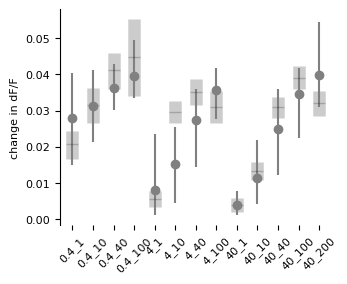

In [27]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace_single.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df1 = df1.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df1, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df1, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=errs_sim_df, linestyle='None', marker='o', color='gray')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")

plt.savefig("posterior_single_exp1.pdf", bbox_inches='tight')

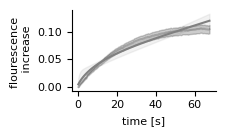

In [28]:
# get the posteriors
simulation_results_single = trace_single.posterior["experiment2"].to_numpy().reshape(-1, data2.shape[1])
simulation_results_mean_single = np.mean(simulation_results_single, axis=0)
simulation_results_conf_single = np.percentile(simulation_results_single, [2.5, 97.5], axis=0)


fig, axs = plt.subplots(1,1, figsize=(2.3,1.4))
axs.plot(time, data2_means, label="Experimental data", alpha=0.2, color='black')
axs.fill_between(time, experiment_conf[0], experiment_conf[1], alpha=0.2, color='black')
# axs.plot(time, simulation_results_mean, label="full model", color='cornflowerblue')
# axs.fill_between(time, simulation_results_conf[0], simulation_results_conf[1], alpha=0.1, color='cornflowerblue')
axs.plot(time, simulation_results_mean_single, label="single ts. model", color='gray')
axs.fill_between(time, simulation_results_conf_single[0], simulation_results_conf_single[1], alpha=0.1, color='gray')
axs.set_xlabel("time [s]")
axs.set_ylabel("flourescence \n increase")
# remove top and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.legend(frameon=False)

plt.tight_layout() 
plt.savefig("posterior_single_exp2.pdf", bbox_inches='tight')
plt.show()

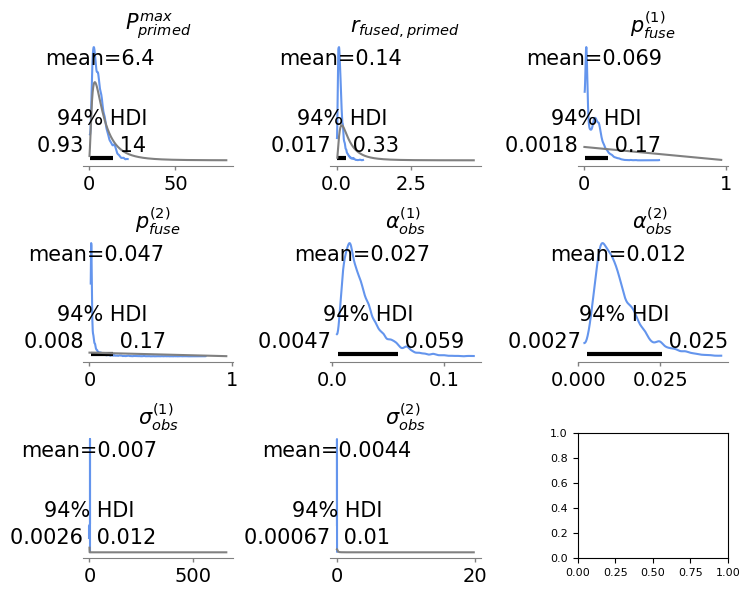

In [29]:
condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions] + ["experiment2"]

name_dict = {
    "max_primed": r"$P^{max}_{primed}$",
    "rate_prime": r"$r_{fused,primed}$",
    "release_probability1": r"$p_{fuse}^{(1)}$",
    "observation_factor1": r"$\alpha_{obs}^{(1)}$",
    "error_model1": r"$\sigma_{obs}^{(1)}$",
    "release_probability2": r"$p_{fuse}^{(2)}$",
    "observation_factor2": r"$\alpha_{obs}^{(2)}$",
    "error_model2": r"$\sigma_{obs}^{(2)}$",
}

# for each variable plot prior and posterior
names_single = [var.name for var in model_single.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names_single = list(filter(fl, names_single))

sidelength = int(np.ceil(np.sqrt(len(names_single))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names_single, range(len(names_single))):
    ax = axs[i]

    pm.plot_posterior(trace_single, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model_single[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace_single.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_single.pdf", bbox_inches='tight')

# Two timescales

In [30]:
# standard parameters
_RATE_RECOVER_TT = 1.0 / 3.0
_RATE_PRIME_TT = 1.0 / 0.5
_MAX_RECOVERY_TT = 40.0
_MAX_PRIMED_TT = 4.0
_MAX_FUSED_TT = 104.0
_RELEASE_PROBABILITY_TT = 0.2

# Define the differential equations
def equations_tt(t, y, args):
    t_args, const_args = args

    RATE_RECOVER = const_args["RATE_RECOVER"]
    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_RECOVERY = const_args["MAX_RECOVERY"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    recovery = y["recovery"]
    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_recovery = RATE_RECOVER * (fused > 0) * (recovery < MAX_RECOVERY)
    recovery_to_primed = 4 * RATE_PRIME * (recovery / MAX_RECOVERY) * (1 - primed / MAX_PRIMED)

    drecovery = fused_to_recovery - recovery_to_primed
    dprimed = recovery_to_primed
    dfused = - fused_to_recovery

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "recovery": drecovery,
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

In [31]:
with pm.Model() as model_tt:

    # Priors on the model parameters
    precision = 2
    mu, sigma = get_lognormal_params(_MAX_RECOVERY_TT, _MAX_RECOVERY_TT/precision)
    max_recovery = pm.LogNormal("max_recovery", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_PRIMED_TT, _MAX_PRIMED_TT/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_RECOVER_TT, _RATE_RECOVER_TT/precision)
    rate_recover = pm.LogNormal("rate_recover", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_PRIME_TT, _RATE_PRIME_TT/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability1 = pm.Beta("release_probability1", alpha=1, beta=2)
    release_probability2 = pm.Beta("release_probability2", alpha=1, beta=2)
    # additional factor to scale from num vesicles to calcium data
    observation_factor1 = pm.Flat("observation_factor1")
    observation_factor2 = pm.Flat("observation_factor2")
    error_model1 = pm.HalfCauchy("error_model1", beta=0.1)
    error_model2 = pm.HalfCauchy("error_model2", beta=0.1)

    const_args_var1 = {
        "RATE_RECOVER": rate_recover,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability1,
    }

    const_args_var2 = {
        "RATE_RECOVER": rate_recover,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability2,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"recovery": max_recovery, "primed": max_primed, "fused": 0.0}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations_tt, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var1)
        release_rate = primed * stim_rate * release_probability1
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor1 * released)

        # get data and simulation results
        data = df1[condition_name]
        error_of_the_mean = np.std(data) / np.sqrt(len(data))
        data_mean = np.mean(data)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model1 + error_of_the_mean)
        
        sim.append(observation_factor1 * released)
        sim_error.append(sigma_error)
        obs.append(data_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    mu1 = sim
    sigma1 = sim_error
    observed1 = obs


    ###### experiment 2
    
    stim_rate = 5.0 # Hz
    max_vesicles = _MAX_FUSED_TT + max_recovery + max_primed


    ### Define starting conditions
    y0 = {"recovery": max_recovery, "primed": max_primed, "fused": _MAX_FUSED_TT - max_primed - max_recovery}

    # Get integrator object
    integrator_object, ts = get_integrator_object2()
    integrator = integrator_object.get_op(equations_tt, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])

    ### Set input
    stim = stim_rate * np.ones(len(ts))
    t_args = stim

    # And solve the ODE for our starting conditions and parameters
    primed, _ = integrator(y0=y0, arg_t=t_args, constant_args=const_args_var2)

    release_rate = primed * stim_rate * release_probability2
    pps_experiment = 1.7
    fused = pm.math.cumsum(release_rate) / pps_experiment # have to get total number of vesicles released
    fused -= fused[0]

    out = pm.Deterministic("experiment2", observation_factor2 * fused)
    sim2_errors = pm.Deterministic("scaled_sigma_error_experiment2", error_model2 + data2_errs)

    mu2 = out
    sigma2 = sim2_errors
    observed2 = data2_means

    observed = np.concatenate([observed1, observed2])
    mu = ptt.concatenate([mu1, mu2])
    sigma = ptt.concatenate([sigma1, sigma2])

    def logp(observed, mu, sigma):
        n = 13

        observed1 = observed[:n]
        observed2 = observed[n:]
        mu1 = mu[:n]
        mu2 = mu[n:]
        sigma1 = sigma[:n]
        sigma2 = sigma[n:]
        weight1 = 10
        weight2 = 1
        normalizer = weight1 + weight2
        weight1 /= normalizer / 2
        weight2 /= normalizer / 2
        p1 = pm.logp(pm.Normal.dist(mu1, sigma1),observed1)
        p2 = pm.logp(pm.Normal.dist(mu2, sigma2),observed2)
        return ptt.concatenate([weight1 * p1, weight2 * p2])

    pm.CustomDist("likelihood",
                    mu, sigma,
                    logp = logp,
                    observed = observed)


In [ ]:
# sample the model
trace_tt = pm.sample(
    model=model_tt,
    tune=800,
    draws=2500,
    cores=4,
    nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
    nuts_sampler="numpyro",
    target_accept=0.9,
)

# save the trace
az.to_netcdf(trace_tt, "trace_tt.nc")


In [33]:
# load the trace
trace_tt = az.from_netcdf("trace_tt.nc")
# if chains do not converge throw them out
trace_tt_full = trace_tt
trace_tt = trace_tt_full.sel(chain=[2,3])
print(az.rhat(trace_tt))

<xarray.Dataset>
Dimensions:                               (experiment2_dim_0: 116,
                                           scaled_sigma_error_experiment2_dim_0: 116)
Coordinates:
  * experiment2_dim_0                     (experiment2_dim_0) int64 0 1 ... 115
  * scaled_sigma_error_experiment2_dim_0  (scaled_sigma_error_experiment2_dim_0) int64 ...
Data variables: (12/38)
    0.4_1                                 float64 1.046
    0.4_10                                float64 1.009
    0.4_100                               float64 1.006
    0.4_40                                float64 1.004
    40_1                                  float64 1.032
    40_10                                 float64 1.039
    ...                                    ...
    scaled_sigma_error_40_40              float64 1.077
    scaled_sigma_error_4_1                float64 1.077
    scaled_sigma_error_4_10               float64 1.077
    scaled_sigma_error_4_100              float64 1.077
    scaled_sigm

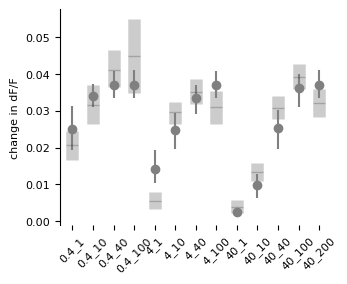

In [34]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace_tt.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df1.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df1.columns, df1.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=errs_sim_df, linestyle='None', marker='o', color='gray')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")
plt.savefig("posterior_tt_exp1.pdf", bbox_inches='tight')


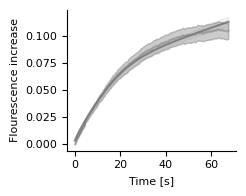

In [35]:
# get the posteriors
simulation_results_tt = trace_tt.posterior["experiment2"].to_numpy().reshape(-1, data2.shape[1])

simulation_results_mean_tt = np.mean(simulation_results_tt, axis=0)
simulation_results_conf_tt = np.percentile(simulation_results_tt, [2.5, 97.5], axis=0)

fig, axs = plt.subplots(1,1, figsize=(2.5,2))
axs.plot(time, data2_means, label="Experimental data", alpha=0.2, color='black')
axs.fill_between(time, experiment_conf[0], experiment_conf[1], alpha=0.2, color='black')
# axs.plot(time, simulation_results_mean, label="Model prediction", color='cornflowerblue')
# axs.fill_between(time, simulation_results_conf[0], simulation_results_conf[1], alpha=0.1, color='cornflowerblue')
axs.plot(time, simulation_results_mean_tt, label="Two timescales", color='gray')
axs.fill_between(time, simulation_results_conf_tt[0], simulation_results_conf_tt[1], alpha=0.1, color='gray')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Flourescence increase")
# remove top and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.legend(frameon=False)

plt.tight_layout() 
plt.savefig("posterior_tt_exp2.pdf", bbox_inches='tight')
plt.show()

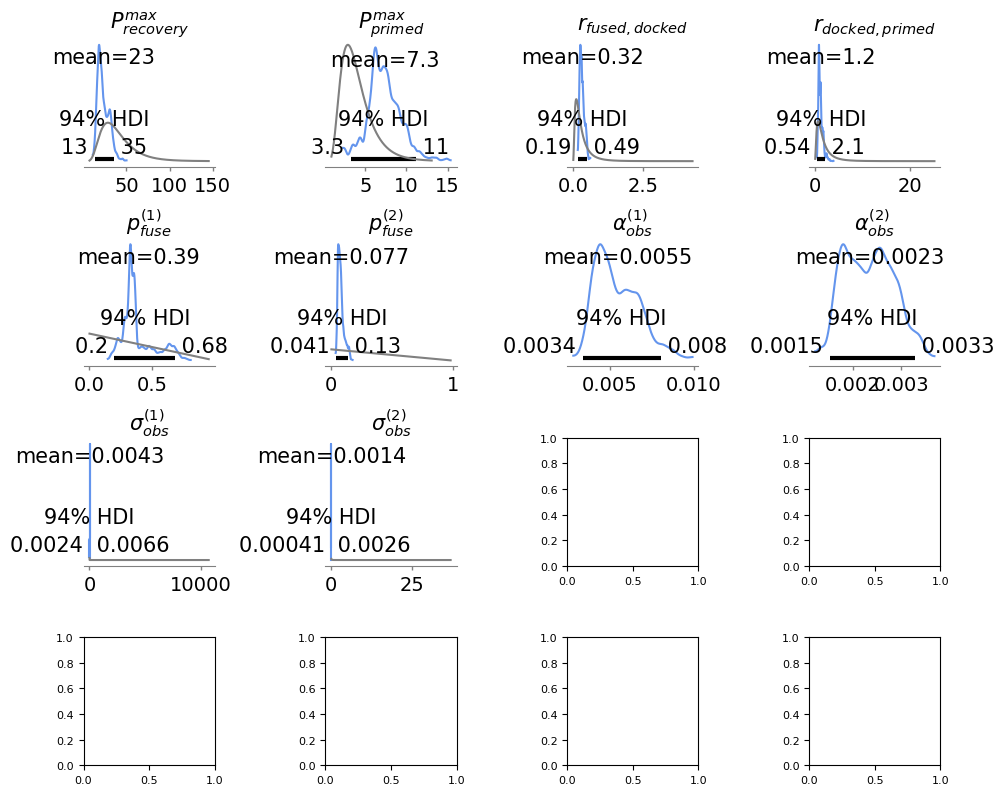

In [36]:
condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions] + ["experiment2"]

name_dict = {
    "max_recovery": r"$P^{max}_{recovery}$",
    "max_primed": r"$P^{max}_{primed}$",
    "rate_recover": r"$r_{fused,docked}$",
    "rate_prime": r"$r_{docked,primed}$",
    "release_probability1": r"$p_{fuse}^{(1)}$",
    "observation_factor1": r"$\alpha_{obs}^{(1)}$",
    "error_model1": r"$\sigma_{obs}^{(1)}$",
    "release_probability2": r"$p_{fuse}^{(2)}$",
    "observation_factor2": r"$\alpha_{obs}^{(2)}$",
    "error_model2": r"$\sigma_{obs}^{(2)}$",
}

# for each variable plot prior and posterior
names_tt = [var.name for var in model_tt.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names_tt = list(filter(fl, names_tt))

sidelength = int(np.ceil(np.sqrt(len(names_tt))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names_tt, range(len(names_tt))):
    ax = axs[i]

    pm.plot_posterior(trace_tt, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model_tt[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace_tt.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_tt.pdf", bbox_inches='tight')

# Model comparision

In [37]:
# load powerlaw trace  
trace_powerlaw = az.from_netcdf("trace_powerlaw.nc")

In [38]:
with model:
    if not "log_likelihood" in trace._groups:
        log_likelihood = pm.compute_log_likelihood(trace)
model_loo = az.loo(trace)

with model_single:
    if not "log_likelihood" in trace_single._groups:
        log_likelihood_single = pm.compute_log_likelihood(trace_single)
model_single_loo = az.loo(trace_single)

with model_tt:
    if not "log_likelihood" in trace_tt._groups:
        log_likelihood_tt = pm.compute_log_likelihood(trace_tt)
model_tt_loo = az.loo(trace_tt)

model_powerlaw_loo = az.loo(trace_powerlaw)

Output()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Output()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Output()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [39]:
comp_loo = az.compare({"full": trace, "single timescale": trace_single, "two timescales": trace_tt, "powerlaw": trace_powerlaw}, ic="loo")
comp_loo

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
full,0,188.394905,6.242952,0.000000,1.000000e+00,20.446309,0.000000,True,log
powerlaw,1,172.008840,11.008928,16.386065,0.000000e+00,19.137613,4.838798,True,log
two timescales,2,169.522290,7.128461,18.872615,0.000000e+00,20.459578,2.146703,True,log
single timescale,3,141.323752,18.837689,47.071153,6.437517e-12,17.098128,7.420342,True,log


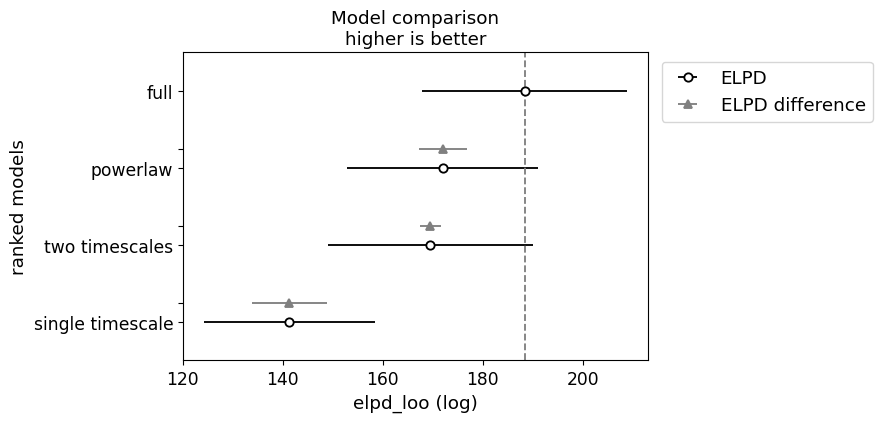

In [40]:
az.plot_compare(comp_loo, insample_dev=False);
plt.savefig("model_comparison.pdf", bbox_inches='tight')

In [41]:
model_waic = az.waic(trace)
model_single_waic = az.waic(trace_single)
model_tt_waic = az.waic(trace_tt)
model_powerlaw_waic = az.waic(trace_powerlaw)

comp_waic = az.compare({"full": trace, "single timescale": trace_single, "two timescales": trace_tt, "powerlaw": trace_powerlaw}, ic="waic")
comp_waic

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: F

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
full,0,188.820215,5.817642,0.000000,1.000000e+00,20.519408,0.000000,True,log
powerlaw,1,173.726179,9.291589,15.094036,0.000000e+00,19.462513,4.321943,True,log
two timescales,2,169.917090,6.733661,18.903125,0.000000e+00,20.525327,2.091660,True,log
single timescale,3,143.430971,16.730470,45.389244,3.974776e-11,17.489765,7.240654,True,log


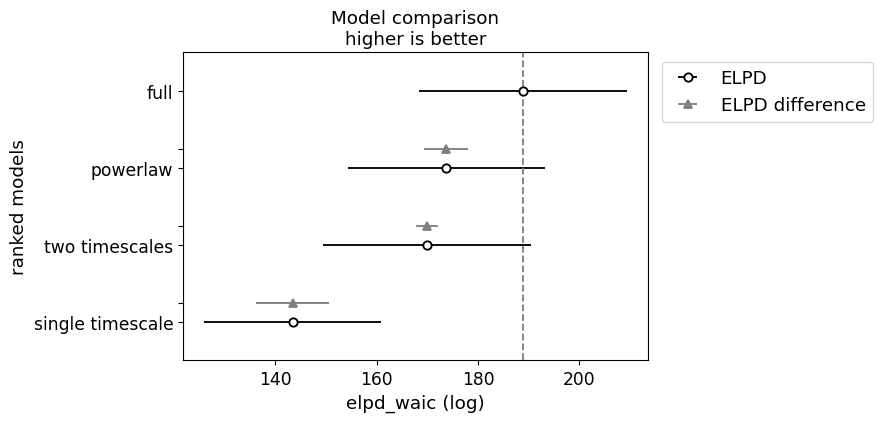

In [42]:
az.plot_compare(comp_waic, insample_dev=False);
plt.savefig("model_comparison_waic.pdf", bbox_inches='tight')